## QUESTION: IS THE COMPAS RISK SCORE BIASED AGAINST BLACK PEOPLE?

# Introduction

For answering the hypothesis of "Is the compas risk scales racially biased against black people?", we need to differentiate between the technical/mathematical perspective and an ethical one. The mathematical correctness will be analysed and to some extend explained by the upcoming code, written in the coding language "Python". More detailed explanation for this part will be provided next to the relevant code.

# Load and preprocess data

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance


A critical aspect of using the COMPAS score for decision support in a jurisdictional context, is the transparency of the model. Without it we cannot guarantee any fairness. Therefore the code of the model and the data used to create it, would need to be accessible by third parties, additionally to the data used to predict the recidivism rate. Transparency also touches the point of how intuitive the code and data is. To what degree can a non expert confirm the fairness of the model or how much time and effort does it require? Providing all the information in an incomprehensible way minimizes the amount of people willing to analyze it. Not only in terms of ensuring fairness, but also in terms of finding statistical errors, this would very much limit the likelihood of finding them. Resulting in a faulty model, either consisting of
conscious or unconscious incorrectness.
Judges, who are using the result of this machine learning model, need to be aware of the possibility of the results being faulty. As models only reflect one perspective and cannot give a complete depicture of the truth. This is partly the reason why judges have not been replaced completly by technology and are only assisting them as of now.

In regards to the machine learning tool "COMPAS" we believe Northpoint made it as transparent as possible, resulting in ProPublica and others, like ourselves, to conduct an independant analyzis.

In [ ]:
url = "https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv?raw=true"
# Load data
raw_data = pd.read_csv(url,index_col="id")
raw_data.head()

,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
id,,,,,,,,,,,,,,,,,,,,,
1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


The raw data has 7214 samples, ProPublica filtered out some of them with the following criteria:
*   -30 <= days_b_screening_arrest <= 30
*   is_recid != -1
*   c_charge_degree != 0
*   score_text!= N/A

In [ ]:
data = (raw_data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text',
             'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score',
             'is_recid', 'two_year_recid']]
             .loc[(raw_data['days_b_screening_arrest'] <= 30) & (raw_data['days_b_screening_arrest'] >= -30), :]
             .loc[raw_data['is_recid'] != -1, :]
             .loc[raw_data['c_charge_degree'] != 'O', :]
             .loc[raw_data['score_text'] != 'N/A', :]
        )

data.shape

(6172, 11)

Now the number of samples match that of ProPublica.

In [ ]:
# Filter data for white defendants and black defendants
white = data['race'] == 'Caucasian'
black = data['race'] == 'African-American'

# group high risk and medium risk group with decile score and call them all high risk
HighRisk = data["decile_score"]>4
HighRisk.name = "HighRisk"

# recode two_year_recid to true false
recid = data["two_year_recid"] == 1
recid.name = "Actual recid"

# EDA

First, we want to investigate at how decile scores are distributed by looking at different diagrams. We can easily recognize that scores are given differently by race. It can easily be recognized that African-American are among the highest mean decile score and have one of the highest standard deviation (alongside Native American).

In [ ]:
# Descriptive statistics of decile score by race
decile_by_race = data.groupby('race')['decile_score'].describe()
decile_by_race

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3175.0,5.276850,2.828073,1.0,3.0,5.0,8.0,10.0
Asian,31.0,2.838710,2.583238,1.0,1.0,2.0,3.0,10.0
Caucasian,2103.0,3.635283,2.562748,1.0,1.0,3.0,5.0,10.0
Hispanic,509.0,3.383104,2.544987,1.0,1.0,3.0,5.0,10.0
Native American,11.0,6.454545,3.012097,2.0,4.5,7.0,9.0,10.0
Other,343.0,2.889213,2.345700,1.0,1.0,2.0,4.0,10.0


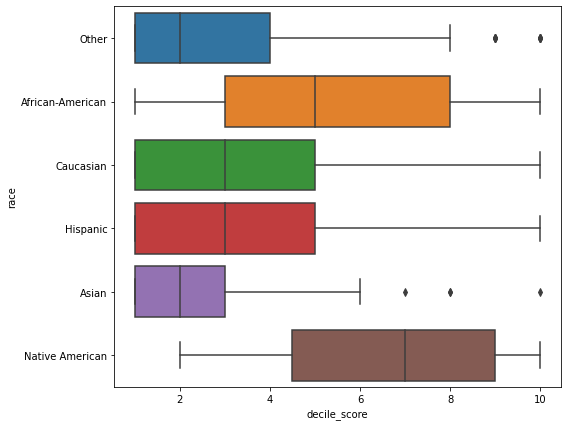

In [ ]:
# Boxplot of decile score by race
plt.figure(figsize=(8,7))
sns.boxplot(x=data["decile_score"], y=data["race"])
plt.show()

## Histograms of decile scores grouped into black and white defendants (conducted by ProPublica)

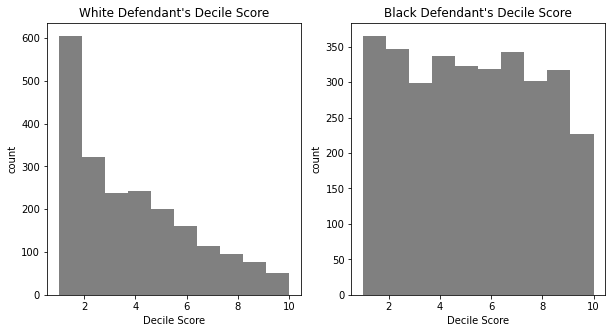

In [ ]:
# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

white = data[data['race'] == 'Caucasian']
black = data[data['race'] == 'African-American']

# Create a histogram for the decile scores of white defendants
axs[0].hist(white['decile_score'], bins=10, color='grey')
axs[0].set_xlabel('Decile Score')
axs[0].set_ylabel('count')
axs[0].set_title("White Defendant's Decile Score")

# Create a histogram for the decile scores of black defendants
axs[1].hist(black['decile_score'], bins=10, color='grey')
axs[1].set_xlabel('Decile Score')
axs[1].set_ylabel('count')
axs[1].set_title("Black Defendant's Decile Score")

plt.show()

As observed from the histograms, the decile scores for white defendants were skewed toward the left, the lower-risk scores, while black defendants were distributed quite evenly across the score categories.

# Data Quality

As we suspect data quality issues may also lead to wrong predictions, we want to investigate Data Quality of the COMPAS dataset with following points:

* Data Imbalance

* Collinearity

* Missing Data

* Outliers

There is clearly an imbalanced proportion between black and white population in the dataset:

In [ ]:
# Check balance in the dataset
total = data.shape[0]
prop_white = data[data['race'] == 'Caucasian'].shape[0] / total
prop_black = data[data['race'] == 'African-American'].shape[0] / total

# Print the results
print("Proportion of white individuals:", prop_white)
print("Proportion of black individuals:", prop_black)

Proportion of white individuals: 0.3401718879955642
Proportion of black individuals: 0.5123371222622678


Looking at the correlation heatmap, the dataset shows moderate relationship between some variables, but not strong enough to be conclusive. Most positive is decile_score and priors_count, and the most negative are age with decile score.

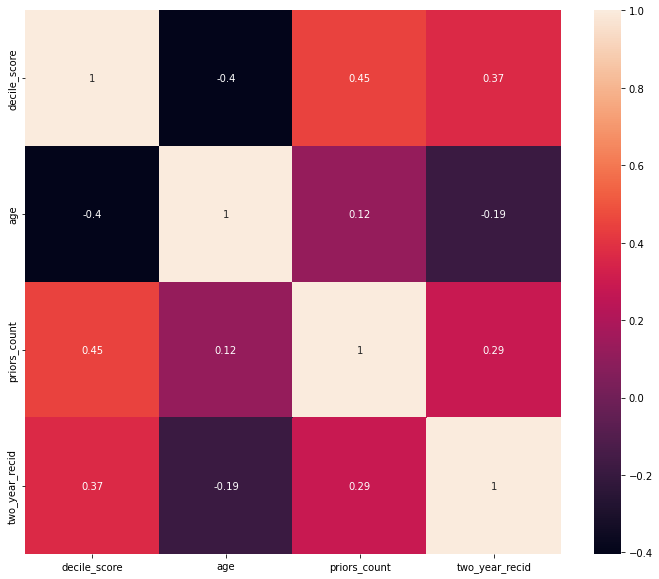

In [ ]:
# Check correlation
df = data[["race","decile_score", "c_charge_degree", "age", "sex", "priors_count", "two_year_recid"]]
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True);

In [ ]:
# Check missing values
race_counts = raw_data.groupby("race").apply(lambda x: x.isna().sum())

# Print the missing value counts for each race
print("Missing value counts by race:")
print(race_counts)

Missing value counts by race:
                  name  first  last  compas_screening_date  sex  dob  age  \
race                                                                        
African-American     0      0     0                      0    0    0    0   
Asian                0      0     0                      0    0    0    0   
Caucasian            0      0     0                      0    0    0    0   
Hispanic             0      0     0                      0    0    0    0   
Native American      0      0     0                      0    0    0    0   
Other                0      0     0                      0    0    0    0   

                  age_cat  race  juv_fel_count  ...  v_decile_score  \
race                                            ...                   
African-American        0     0              0  ...               0   
Asian                   0     0              0  ...               0   
Caucasian               0     0              0  ...               0  

In [ ]:
# Check outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identify the variables with outliers
outliers = data[((data < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Count outliers of each race
race_counts = df.loc[outliers.index]["race"].value_counts()
print("Outlier counts by race:")
print(race_counts)

Outlier counts by race:
African-American    401
Caucasian           100
Hispanic             25
Other                11
Native American       2
Asian                 1
Name: race, dtype: int64


<ipython-input-76-dce8c4108baf>:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = data[((data < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


The COMPAS dataset exhibits several data quality issues, particularly with regards to the Black defendants. The dataset is imbalanced, with a disproportionate number of Black individuals compared to other races, and it has been found to contain a higher number of missing values and outliers. These data quality issues raise important concerns about the fairness and accuracy of the COMPAS risk assessment tool.

# In terms of error rates, COMPAS is biased

Going deeper into the ethical part of the question, if the COMPAS score is fair, we will not find a single correct answer. Each approach to answer this topic will only display one perspective. Meaning multiple approaches hold valid points, which should not be disregarded for the decision making process of whether or not to use COMPAS scores. In this case more specifally being the usage in jurisdictional decisions on previous criminals considering their recidivism risk. The goal is to empathize this predicament, which is in large caused by the terminology of **fairness**. As fairness is a complex topic but an everyday used word, it can easily lead to intuitive thinking of what the term fairness actually means. As our intuition is based on our core believes and experiences, we are holding on to our idea and rarely change it. Combining that fact with the common word of "fairness", an illusion of knowledge is created.
The easiest approach to fairness would be to say everybody is being treated equaly. Protecting the categories "age", "sex", "race" and "name" to not be used by the model. "Name" because it could be possible to derive the culture and therefore the race from it.
Sidenote: The fact to have a category "race" in the data, is in itself a view of humans being inequal to each other.
The equality approach would result in underfitting and overfitting data. In other words: By excluding valuable categories (in terms for accuracy), the prediction of recidivism will be more generic and end up with risk predictions being too high or too low in many cases.

Going into the other extreme you would include every aspect of data available to us, into the machine learning. This would give the model a high accuracy rate on paper. One of the counter arguments to use this approach, would be the rather obvious discrimination inside the model. As you would transfer the discrimination from peoples minds with statements like: "This person is more likely to re-offend because he/she is black", even if it is only an unconscious thought, towards a technical system. Every code is only as good as the programmer and the data provided to the system. Every decision regarding the code and data input is influencing the performance and learning capabilities of the system.
Even if there would be a clear correlation between recidivsm and the race, race is not the logical deciding factor. Many factors merge in the classifier "race", e.g. level of education, income, parental income, criminal rate of the neighbourhood, job market, etc, which are more likely to be the drivers of recidivism.

In this report we apply the latter mentioned, due to a too low accuracy by not using relevant categories. However we are aware that e.g. "race" does not have a logical causality between it and recidivism. All the previous mentioned factors are hidden behind the category "race", which would need to be split into separate categories. For that the dataset would need to be expanded by gathering all the missing data.
Because minorities in the US tend to perform poorly in these categories, it would be an incorrect conclusion to say minorities in general recide more. It is more a consequence of the circumstances they live in, that they recide. But we receive an increased accuracy in predicting the recidivism by using the information that the person in question is part of a specific group. Therefore we decided to use this factor as well.
At this point we like to emphatize the importance of the judge to make a decision not only based on the score of a model but also by other factors, not included in a model like COMPAS. To solve the issue of disparity within the hidden categories behind "race", politic and society need to work on a long term improvement and ultimataly a total equality between all communities.
Once that is achieved, the model cannot use "race" as a increasing accuracy factor for the prediction anymore.


Next, we could conduct some cross tables to see the scores for each race

In [ ]:
pd.crosstab(data['score_text'],data['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
score_text,,,,,,
High,845,3,223,47,4,22
Low,1346,24,1407,368,3,273
Medium,984,4,473,94,4,48


## Some confusion matrices to prove ProPublica's points

In [ ]:
recid = np.where(raw_data["two_year_recid"]==1, True, False)
HighRisk = np.where(raw_data["decile_score"]>4, True, False)
white = np.where(raw_data["race"]=="Caucasian", True, False)
black = np.where(raw_data["race"]=="African-American", True, False)

In [ ]:
cm = pd.crosstab(recid,HighRisk)
cm

col_0,False,True
row_0,,
False,2681,1282
True,1216,2035


In [ ]:
# confusion matrix for white defendants
cm_white = pd.crosstab(recid[white],HighRisk[white])
cm_white

col_0,False,True
row_0,,
False,1139,349
True,461,505


In [ ]:
# confusion matrix for black defendants
cm_black = pd.crosstab(recid[black],HighRisk[black])
cm_black

col_0,False,True
row_0,,
False,990,805
True,532,1369


In [ ]:
def compute_metrics(matrix, table_name=''):
    # false positive rate
    FPR = matrix.iloc[0,1]/(matrix.iloc[0,1]+matrix.iloc[0,0])

    # false negative rate
    FNR = matrix.iloc[1,0]/(matrix.iloc[1,0]+matrix.iloc[1,1])

    # positive predictive values
    PPV = matrix.iloc[1,1]/(matrix.iloc[0,1]+matrix.iloc[1,1])

    # negative predictive values
    NPV = matrix.iloc[0,0]/(matrix.iloc[0,0]+matrix.iloc[1,0])


    index = ["FPR", "FNR", "PPV", "NPV"]
    df = pd.DataFrame(index=index, columns=['Percent'])
    df.Percent = FPR, FNR, PPV, NPV
    df.index.name = table_name
    return df

In [ ]:
compute_metrics(cm,"All defendants")

,Percent
All defendants,
FPR,0.323492
FNR,0.374039
PPV,0.613506
NPV,0.687965


In [ ]:
compute_metrics(cm_white,"White defendants")

,Percent
White defendants,
FPR,0.234543
FNR,0.477226
PPV,0.591335
NPV,0.711875


In [ ]:
compute_metrics(cm_black,"Black defendants")

,Percent
Black defendants,
FPR,0.448468
FNR,0.279853
PPV,0.629715
NPV,0.650460


From ProPublica's view, these are problematic for two reasons:


1.   Regarding FPR: Black non-recidivists were nearly twice as likely to be misclassified as higher risk compared to their white counterparts (44.9 percent vs. 23.5 percent)
2.   Regarding FNR: White defendants who recidivated were mistakenly labeled low risk almost twice as often as black re-offenders (47.7 percent vs. 28.0 percent).

> **In terms of error rates, COMPAS risk scores are racially biased.**





**As a result, if the error rates are equal, it is the PPV and NPV that would be different, so it will not satisfy Northpointe's definition of fairness: The chances of being predicted positive for both groups in the same class should be the same.**

## AUC & ROC Curve to prove Northpointe's view of fairness

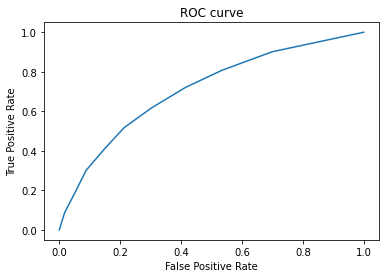

AUC Score for logistic regression model = 0.7097888069940436
Accuracy =  0.6607258587167855


In [ ]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(data.two_year_recid, data.decile_score)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Calculate AUC
auc = roc_auc_score(data.two_year_recid, data.decile_score)
print("AUC Score for logistic regression model =", auc)


# Calculate accuracy
accuracy = accuracy_score(data.two_year_recid, data.decile_score>4)
print("Accuracy = ", accuracy)

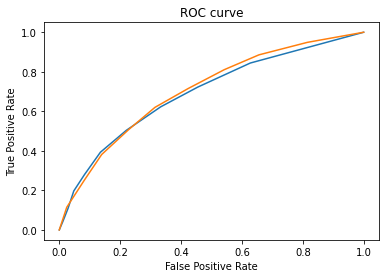

AUC Score for white defendants = 0.6927625543456584
AUC Score for black defendants = 0.7042527817830293
Accuracy fro white defendants =  0.6718972895863052
Accuracy fro black defendants =  0.6491338582677165


In [ ]:
# Compute the ROC curve
white = np.where(data["race"]=="Caucasian", True, False)
black = np.where(data["race"]=="African-American", True, False)

fpr_w, tpr_w, _ = roc_curve(data[white].two_year_recid, data[white].decile_score)
fpr_b, tpr_b, _ = roc_curve(data[black].two_year_recid, data[black].decile_score)

# Plot the ROC curve
plt.plot(fpr_w, tpr_w)
plt.plot(fpr_b, tpr_b)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Calculate AUC
auc_w = roc_auc_score(data[white].two_year_recid, data[white].decile_score)
auc_b = roc_auc_score(data[black].two_year_recid, data[black].decile_score)
print("AUC Score for white defendants =", auc_w)
print("AUC Score for black defendants =", auc_b)


# Calculate accuracy
accuracy_w = accuracy_score(data[white].two_year_recid, data[white].decile_score>4)
accuracy_b = accuracy_score(data[black].two_year_recid, data[black].decile_score>4)
print("Accuracy for white defendants = ", accuracy_w)
print("Accuracy for black defendants = ", accuracy_b)

This is Northpointe's view of fairness: If we choose the same threshold for both groups to identify which is high and low score, it is apparent that they perform the same for both white and black defendants (white 69% and black 70%)

# However, what can be changed?

* It is clear that with the current error rates, it is unfair for black defendants.

* However, it is not as easy as it sounds, because like Washington Post did comment, it is mathematically impossible.

Let's try some changes so that we could have the same error rates for black and white defendants, by changing the threshold for risk score.

In [ ]:
white = data[data['race'] == 'Caucasian']
black = data[data['race'] == 'African-American']

In [ ]:
def changing_threshold(data):
  index = np.arange(1, 10)
  columns = ['FPR', 'FNR', 'PPV', 'NPV']
  table = pd.DataFrame(index=index, columns=columns, dtype=float)


  for threshold in index:
    # group high risk and medium risk group with decile score and call them all high risk
    HighRisk = data["decile_score"]>threshold
    HighRisk.name = "HighRisk"
    recid = data["two_year_recid"] == 1
    cm = pd.crosstab(recid,HighRisk)
    metrics = compute_metrics(cm)
    table.loc[threshold] = metrics['Percent']

  table['FPR'].plot()
  table['FNR'].plot()

  plt.xlabel("Threshold")
  plt.ylabel("Percentage")
  plt.title("Changing thresholds and error rates")
  plt.legend()
  return table

,FPR,FNR,PPV,NPV
1,0.699970,0.098612,0.518215,0.784603
2,0.534047,0.192595,0.558071,0.743359
3,0.414213,0.279459,0.592332,0.715064
4,0.302706,0.383054,0.629953,0.685472
5,0.212905,0.482734,0.669894,0.661254
6,0.147190,0.592382,0.698171,0.632833
7,0.088314,0.698469,0.740385,0.609785
8,0.053226,0.805981,0.752762,0.584435
9,0.017544,0.912780,0.805921,0.563054


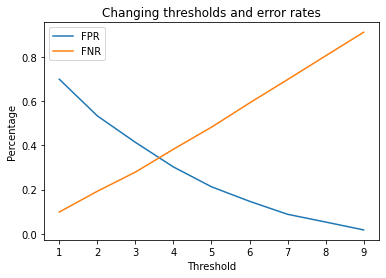

In [ ]:
changing_threshold(data)

In [ ]:
white = np.where(data["race"]=="Caucasian", True, False)
black = np.where(data["race"]=="African-American", True, False)

,FPR,FNR,PPV,NPV
1,0.627635,0.155718,0.463284,0.788430
2,0.455113,0.277372,0.504673,0.753780
3,0.333333,0.377129,0.545261,0.733677
4,0.220141,0.496350,0.594828,0.710021
5,0.135051,0.607056,0.651210,0.689484
6,0.082748,0.720195,0.684524,0.664969
7,0.047619,0.802920,0.726457,0.648936
8,0.028884,0.890511,0.708661,0.629555
9,0.011710,0.957421,0.700000,0.616659


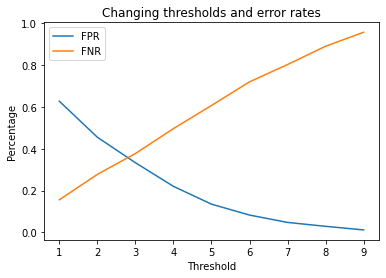

In [ ]:
changing_threshold(data[white])

,FPR,FNR,PPV,NPV
1,0.815059,0.051174,0.560854,0.767123
2,0.655878,0.114389,0.596997,0.732771
3,0.541612,0.189645,0.621422,0.687810
4,0.423382,0.284768,0.649535,0.648588
5,0.314399,0.379892,0.683931,0.621929
6,0.227873,0.492474,0.709596,0.588324
7,0.139366,0.618302,0.750296,0.559227
8,0.082563,0.747742,0.770221,0.527936
9,0.024439,0.885611,0.837004,0.501018


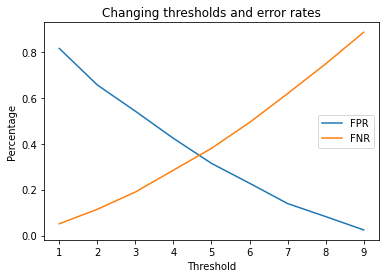

In [ ]:
changing_threshold(data[black])

As observed in the diagrams above, the FPR and FNR vary differently. In order to get the same error rates for both groups, we have to use different thresholds for different groups. Further, once we vary the thresholds, the predictive values are also varying.

Example: choose 3 for white and 5 for black because the FPR and FNR seem kind of equal.
* When in the higher risk class, White defendants would have 55% chance of being correctly predicted as recidivists, while black counterparts would have 68% chance.
* Originally, white and black defendants have 59% and 65% respectively.


# Logistic Regression

## Preprocess data

In [ ]:
pd.crosstab(data["score_text"],data["decile_score"])

decile_score,1,2,3,4,5,6,7,8,9,10
score_text,,,,,,,,,,
High,0,0,0,0,0,0,0,420,420,304
Low,1286,822,647,666,0,0,0,0,0,0
Medium,0,0,0,0,582,529,496,0,0,0


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import logit
# We want another variable that combines Medium and High
# for this purpose, we are using the score text instead of decile scores

#Turning the categorical variables into dummies
catCols = ['score_text','age_cat','sex','race','c_charge_degree']
data.loc[:,catCols] = data.loc[:,catCols].astype('category')

dfDummies = pd.get_dummies(data = data, columns=catCols)

# Clean column names
new_column_names = [col.lstrip().rstrip().lower().replace(" ", "_").replace("-", "_") for col in dfDummies.columns]
dfDummies.columns = new_column_names

# We want another variable that seperates decile score into high and low classe
dfDummies['score_text_medhigh'] = dfDummies['score_text_high'] + dfDummies['score_text_medium']

dfDummies.head()

,age,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,score_text_high,score_text_low,score_text_medium,age_cat_25___45,...,sex_male,race_african_american,race_asian,race_caucasian,race_hispanic,race_native_american,race_other,c_charge_degree_f,c_charge_degree_m,score_text_medhigh
id,,,,,,,,,,,,,,,,,,,,,
1,69,0,-1.0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
3,34,0,-1.0,3,1,1,0,1,0,1,...,1,1,0,0,0,0,0,1,0,0
4,24,4,-1.0,4,1,1,0,1,0,0,...,1,1,0,0,0,0,0,1,0,0
7,44,0,0.0,1,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,1,0
8,41,14,-1.0,6,1,1,0,0,1,1,...,1,0,0,1,0,0,0,1,0,1


In [ ]:
dfDummies.columns

Index(['age', 'priors_count', 'days_b_screening_arrest', 'decile_score',
       'is_recid', 'two_year_recid', 'score_text_high', 'score_text_low',
       'score_text_medium', 'age_cat_25___45', 'age_cat_greater_than_45',
       'age_cat_less_than_25', 'sex_female', 'sex_male',
       'race_african_american', 'race_asian', 'race_caucasian',
       'race_hispanic', 'race_native_american', 'race_other',
       'c_charge_degree_f', 'c_charge_degree_m', 'score_text_medhigh'],
      dtype='object')

In [ ]:
logReg = logit('score_text_medhigh ~ sex_female + age_cat_greater_than_45 + age_cat_less_than_25 + race_african_american + race_asian + race_hispanic + race_native_american + race_other + priors_count + c_charge_degree_m + two_year_recid',data=dfDummies
).fit()

print(logReg.summary())


Optimization terminated successfully.
         Current function value: 0.499708
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     score_text_medhigh   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6160
Method:                           MLE   Df Model:                           11
Date:                Mon, 30 Jan 2023   Pseudo R-squ.:                  0.2729
Time:                        15:06:07   Log-Likelihood:                -3084.2
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.5255      0.079    -19.430      0.000      -1.679   

From this model, we could see that age has the most impact, therefore the most predicitve feature. Generally, defendants less than 25 years old is 2.6 times more than defendants with age greater than 45 to get a higher score, considering all other factors.



In [ ]:
# probability of the outcome being 1 when all independent variables are equal to 0, meaning no coefficients
control = np.exp(-1.5255) / (1 + np.exp(-1.5255))

Female defendants have a 19% higher than men to get a high risk score.

In [ ]:
# the probability of the outcome being 1 when the independent variable changes by 1 unit
np.exp(0.2213) / (1 - control + (control * np.exp(0.2213)))

1.1948243807769987

Race is the next important factor. Already considering other factors, blacks have a chance of 45% more than whites to get a high risk score.

In [ ]:
# the probability of the outcome being 1 when the independent variable changes by 1 unit
np.exp(0.4772) / (1 - control + (control * np.exp(0.4772)))

1.452825407001621

## Train test split for logistic regression model

In [ ]:
# splitting our dataset into train and test datasets
train_set, test_set = train_test_split(dfDummies, test_size = 0.3, random_state = 42)

In [ ]:
formula = 'score_text_medhigh ~ sex_female + age_cat_greater_than_45 + age_cat_less_than_25 + race_african_american + race_asian + race_hispanic + race_native_american + race_other + priors_count + c_charge_degree_m + two_year_recid'
fit_logit_train = logit(formula, train_set).fit()
train_pred = fit_logit_train.predict(test_set)

Optimization terminated successfully.
         Current function value: 0.500879
         Iterations 6


In [ ]:
# Calculate confusion matrix
ConfMat = confusion_matrix(test_set.score_text_medhigh, train_pred>0.5)
print("Confusion Matrix: \n", pd.DataFrame(ConfMat))

Confusion Matrix: 
      0    1
0  815  209
1  259  569


## ROC & AUC

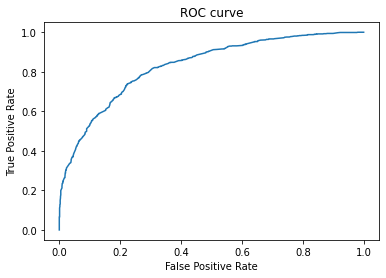

AUC Score for logistic regression model = 0.8307999320652173
Accuracy for logistic regression model =  0.7473002159827213


In [ ]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(test_set.score_text_medhigh, train_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Calculate AUC
auc_logreg = roc_auc_score(test_set.score_text_medhigh, train_pred)
print("AUC Score for logistic regression model =", auc_logreg)


# Calculate accuracy
accuracy_logreg = accuracy_score(test_set.score_text_medhigh, train_pred>0.5)
print("Accuracy for logistic regression model = ", accuracy_logreg)


In [ ]:
white = test_set["race_caucasian"]==1
black = test_set["race_african_american"]==1

### ROC & AUC of both groups in comparison

In [ ]:
import warnings

warnings.simplefilter("ignore")

AUC Score for white defendants = 0.8161026824604872
AUC Score for black defendants = 0.8049225589225589


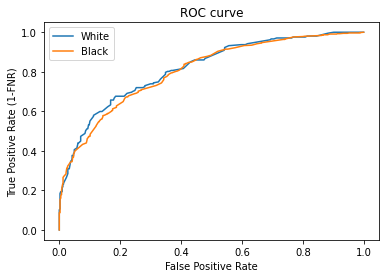

In [ ]:
# Compute the ROC curves
fprw, tprw, thresholdsw = roc_curve(test_set[white].score_text_medhigh, train_pred[white])
fprb, tprb, thresholdsb = roc_curve(test_set[black].score_text_medhigh, train_pred[black])

# Calculate AUCs
auc_white = roc_auc_score(test_set[white].score_text_medhigh, train_pred[white])
auc_black = roc_auc_score(test_set[black].score_text_medhigh, train_pred[black])

print("AUC Score for white defendants =", auc_white)
print("AUC Score for black defendants =", auc_black)

# Plot the ROC curve
plt.plot(fprw, tprw,label="White")
plt.plot(fprb,tprb,label="Black")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (1-FNR)')
plt.title('ROC curve')
plt.legend()
plt.show()


*   Currently, the ROC curves look pretty similar for both categories, meaning we are now reaching a similar error rate (FPR and FNR) for the two groups.

*   Furthermore, the AUC scores also show quite "accuracy equity" (both are appr. 80%).

> **This is definition of fairness for Northpointe: whoever has the same risk score has the same chance of being predicted of getting recharged, also meaning having the same predictive values.**



## Cross validation

Though the score is quite good, we would want to see if this score was produced based on this specific training data or not.

Mean of AUC Score is  0.829 with standard deviation =  0.0167 


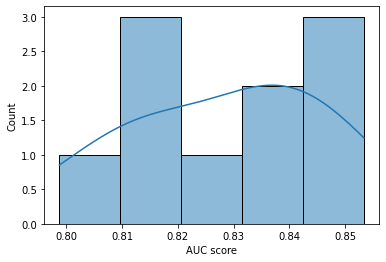

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

y = dfDummies["score_text_medhigh"]
X = dfDummies[["sex_male","sex_female","age_cat_greater_than_45","age_cat_less_than_25",
               "race_caucasian","race_african_american","race_asian","race_hispanic","race_native_american","race_other",
               "priors_count","c_charge_degree_m","two_year_recid"]]

LogReg = LogisticRegression(random_state=42)

cv_results = cross_val_score(LogReg,X,y,scoring="roc_auc",cv=10)

ax = sns.histplot(x=cv_results, kde=True)
plt.xlabel("AUC score")

print(f"Mean of AUC Score is {np.mean(cv_results) : .3f} with standard deviation = {np.std(cv_results) : .4f} ")

The score we got above is, as a result, quite representative.

# Tree-based model

## First model we want to try is Random Forest

In [ ]:
print(data.dtypes)

age                           int64
c_charge_degree            category
race                       category
age_cat                    category
score_text                 category
sex                        category
priors_count                  int64
days_b_screening_arrest     float64
decile_score                  int64
is_recid                      int64
two_year_recid                int64
dtype: object


In [ ]:
# Convert categorical features to numeric levels
le = LabelEncoder()
for feature in data.columns:
    if data[feature].dtype=="category":
      data[feature] = le.fit_transform(data[feature])
      print(feature)
      print(le.classes_)
    elif data[feature].dtype=="object":
      data[feature] = le.fit_transform(data[feature])
      print(feature)
      print(le.classes_)

c_charge_degree
['F' 'M']
race
['African-American' 'Asian' 'Caucasian' 'Hispanic' 'Native American'
 'Other']
age_cat
['25 - 45' 'Greater than 45' 'Less than 25']
score_text
['High' 'Low' 'Medium']
sex
['Female' 'Male']


In [ ]:
X = data[["age","c_charge_degree","race","sex","priors_count","two_year_recid"]]

data["decile_score_binary"] = np.where(data["decile_score"]>4,1,0)
y = data["decile_score_binary"]

In [ ]:
data.dtypes

age                          int64
c_charge_degree              int64
race                         int64
age_cat                      int64
score_text                   int64
sex                          int64
priors_count                 int64
days_b_screening_arrest    float64
decile_score                 int64
is_recid                     int64
two_year_recid               int64
decile_score_binary          int64
dtype: object

In [ ]:
# Split into train & test sets
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def create_random_forest(X,y,n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2,
                         min_samples_leaf=1, max_features='sqrt', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None,
                         random_state=42, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None):
  # Split into train & test sets
  X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

  # initiate random forest
  global rf_clf
  rf_clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split, criterion=criterion,
                                min_samples_leaf=min_samples_leaf, max_features=max_features, max_depth=max_depth,
                                class_weight=class_weight, bootstrap=bootstrap, random_state=random_state)

  # Fit the model on the training data
  rf_clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = rf_clf.predict_proba(X_test)

  # Extract prediction prob
  global y_pred_prob
  y_pred_prob = y_pred[:,1]

  # Calculate AUC score
  global auc_rf
  auc_rf = roc_auc_score(y_test, y_pred_prob)
  if auc_rf > auc_logreg:
    print("AUC Score for random forrest =", auc_rf, ">",auc_logreg)
  else:
    print("AUC Score for random forrest =", auc_rf, "=<",auc_logreg)

  return y_pred_prob,rf_clf,auc_rf

In [ ]:
create_random_forest(X,y)

AUC Score for random forrest = 0.7888301536080918 =< 0.8307999320652173


(array([1.        , 0.627     , 0.30714286, ..., 0.734     , 0.39535424,
        0.12      ]),
 RandomForestClassifier(max_features='sqrt', random_state=42),
 0.7888301536080918)

# Hypertuning paramater

For this, we will try GridSearchCV to find the best hyperparameter (n_estimators) for the random forest.

In [ ]:
"""
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
param_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
                'class_weight': ['balanced', 'balanced_subsample']
              }
rf_clf = RandomForestClassifier()
rf_cv = RandomizedSearchCV(rf_clf, param_grid, cv=10, scoring ="roc_auc")
rf_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(rf_cv.best_params_))
#print("Best score is {}".format(rf_cv.best_score_))
"""

SyntaxError: ignored

In [ ]:
create_random_forest(X,y,n_estimators=200, min_samples_split=5,min_samples_leaf=4,
                     max_features="auto",max_depth=20,class_weight="balanced",bootstrap="True")

AUC Score for random forrest = 0.8310824039477658 > 0.8307999320652173


(array([0.95283008, 0.29796374, 0.32761888, ..., 0.54914837, 0.43240163,
        0.29551713]),
 RandomForestClassifier(bootstrap='True', class_weight='balanced', max_depth=20,
                        min_samples_leaf=4, min_samples_split=5,
                        n_estimators=200, random_state=42),
 0.8310824039477658)

In [ ]:
"""
from sklearn.model_selection import GridSearchCV
param_grid = { 'max_depth': np.arange(50,100),
               'min_samples_leaf': np.arange(10,100),
               'min_samples_split': np.arange(4,100),
               'n_estimators': np.arange(1400,1800),
              }
rf_cv = GridSearchCV(rf_clf, param_grid, cv=10, scoring ="roc_auc")
rf_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(rf_cv.best_params_))
#print("Best score is {}".format(rf_cv.best_score_))
"""

In [ ]:
# best score until now
create_random_forest(X,y,n_estimators=1400, min_samples_split=4,
                                min_samples_leaf=13, max_features= 'auto',
                                max_depth=54, class_weight='balanced_subsample',
                                bootstrap=True, random_state=42)

AUC Score for random forrest = 0.8390924573520533 > 0.8307999320652173


(array([0.93083229, 0.22275126, 0.46217151, ..., 0.54053943, 0.44272323,
        0.4172541 ]),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=54,
                        min_samples_leaf=13, min_samples_split=4,
                        n_estimators=1400, random_state=42),
 0.8390924573520533)

Mean of AUC Score is  0.838 with standard deviation =  0.0195 


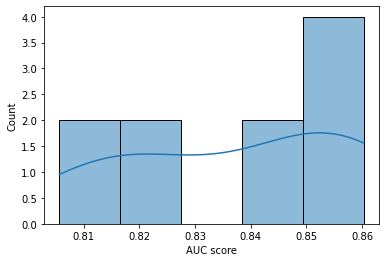

In [ ]:
cv_results = cross_val_score(rf_clf,X,y,scoring="roc_auc",cv=10)

ax = sns.histplot(x=cv_results, kde=True)
plt.xlabel("AUC score")

print(f"Mean of AUC Score is {np.mean(cv_results) : .3f} with standard deviation = {np.std(cv_results) : .4f} ")

In [ ]:
importance = rf_clf.feature_importances_
importance = sorted(importance, reverse=True)

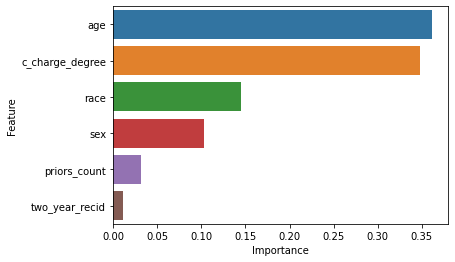

In [ ]:
# Create a bar plot of the feature importances
sns.barplot(x=importance, y= X.columns)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Comparison of the two models

In [ ]:
from sklearn.metrics import classification_report
report_rf = classification_report(y_test,y_pred_prob>0.5)
report_logreg = classification_report(test_set.score_text_medhigh, train_pred>0.5)
print("Report for random forest \n", report_rf)
print("Report for logit \n", report_logreg)

Report for random forest 
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      1024
           1       0.73      0.75      0.74       828

    accuracy                           0.76      1852
   macro avg       0.76      0.76      0.76      1852
weighted avg       0.76      0.76      0.76      1852

Report for logit 
               precision    recall  f1-score   support

           0       0.76      0.80      0.78      1024
           1       0.73      0.69      0.71       828

    accuracy                           0.75      1852
   macro avg       0.75      0.74      0.74      1852
weighted avg       0.75      0.75      0.75      1852



Add interpretation here!

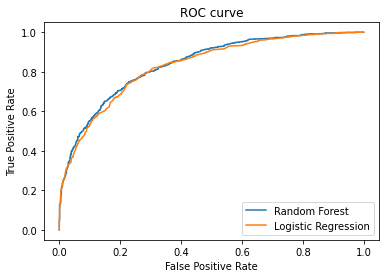

In [ ]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
fpr1, tpr1, thresholds1 = roc_curve(test_set.score_text_medhigh,train_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label = "Random Forest")
plt.plot(fpr1, tpr1, label = "Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

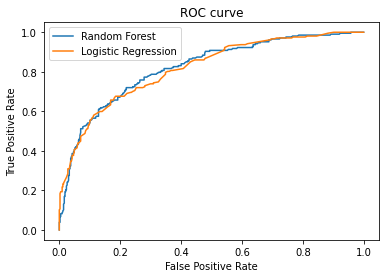

In [ ]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test[white], y_pred_prob[white])
fpr1, tpr1, thresholds1 = roc_curve(test_set[white].score_text_medhigh,train_pred[white])

# Plot the ROC curve
plt.plot(fpr, tpr, label = "Random Forest")
plt.plot(fpr1, tpr1, label = "Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

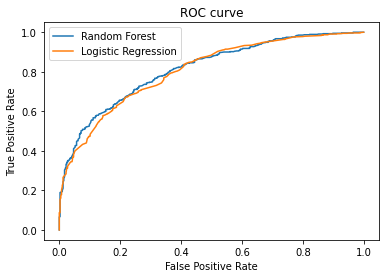

In [ ]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test[black], y_pred_prob[black])
fpr1, tpr1, thresholds1 = roc_curve(test_set[black].score_text_medhigh,train_pred[black])

# Plot the ROC curve
plt.plot(fpr, tpr, label = "Random Forest")
plt.plot(fpr1, tpr1, label = "Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

# Counterfactuals

In [ ]:
!pip install dice_ml
import dice_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data = data[["age","c_charge_degree","race","sex","priors_count","two_year_recid","decile_score_binary"]]

In [ ]:
# Dataset
data_dice = dice_ml.Data(dataframe=data,
                         # For perturbation strategy
                         continuous_features=["priors_count","age"],
                         outcome_name="decile_score_binary")
# Model
clf_dice = dice_ml.Model(model=rf_clf,
                        # There exist backends for tf, torch, ...
                        backend="sklearn")

# Explainer
explainer = dice_ml.Dice(data_dice, # data input
                         clf_dice, # the model we are using
                         method="random")

In [ ]:
# Create explanation
# Generate CF based on the blackbox model
input_datapoint = X_test[0:1]
input_datapoint

,age,c_charge_degree,race,sex,priors_count,two_year_recid
id,,,,,,
4086,26,1,0,1,13,1


In [ ]:
# Create feasible (conditional) Counterfactuals
permitted_range={"race":['0','2']} # 0 = black, 2 = white
cf = explainer.generate_counterfactuals(input_datapoint,
                                  total_CFs=10,
                                  permitted_range=permitted_range,
                                  desired_class="opposite")
# Visualize it
cf.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:04<00:00,  4.11s/it]

Query instance (original outcome : 1)


,age,c_charge_degree,race,sex,priors_count,two_year_recid,decile_score_binary
0,26,1,0,1,13,1,1



Diverse Counterfactual set (new outcome: 0.0)


,age,c_charge_degree,race,sex,priors_count,two_year_recid,decile_score_binary
0,96,1,2,1,5,1,0
1,58,1,2,1,9,1,0
2,52,1,0,1,3,1,0
3,-,1,0,1,0,0,0
4,40,1,0,1,1,1,0
5,-,1,0,1,0,1,0
6,54,1,0,1,2,1,0
7,88,1,0,1,0,1,0
8,-,1,0,1,1,0,0
9,61,0,0,1,3,1,0


## What extra value do they bring?

Among the 10 counterfactuals generated, there are some interesting patterns:


1.   The model seems to make predictions based pretty much on priors_count, unlike the importance graph showed.
2.   Age also changes drastically in order to change risk score from high to low.
3.   Despite being second on the importance ranking, there is only one scenario where we should change c_charge_degree to flip the class.
4. Regarding Race, there are also only two scenarios that suggest changing Race would change the class. And in both cases, it is worth mentioning that the priors_count and age also changed significantly.

**That means if we want to get the score from high to low, and if race is flipped, it is highly possible that the priors_count also needs to be reduced, and age should also vary. Therefore, based on explanations made by counterfactuals, COMPAS does not predict the risk score base on race much, but most on priors_count and age, which is supported by both logistic regression and random forest.**



## What assumptions are made in Counterfactuals?



*   Counterfactual explanations typically assume that the model is locally linear, meaning that small changes to the input should result in small changes to the prediction.
*   Additionally, counterfactual explanations assume that the model is able to make accurate predictions, so if the model is not performing well, the explanations may not be meaningful.




# Critical acclaims

Jurisdictional laws need to be adapted in order to use big data throughout police activities. (e.g. body cams). As of now privacy is being violated through such instruments.
(Combatting Police Discrimination in the Age of Big Data, Shard Goel et al. New Criminal Law Review, Volume 20, Issue 2, 2017, https://online.ucpress.edu/nclr/article/20/2/181/68886/Combatting-Police-Discrimination-in-the-Age-of-Big)
Introducing more tools like that would increase the fairness in catching criminals. This would increase our fairness in the compas score as well, as the police is responsible
for our data input. Through news, especially from the USA, one could get the impression of black people getting treated more harshly by the police than the white population.
Possibly resulting in more black people being taken into custody and therefore being a negative impact on the recidivism rate for black people.
This claim is supported by the so called "Terry stop", also named "stop and frisk". This instrument allows the police in the united states to detain, question and search people
for illegal posessions on the basis of "reasonable, articulable suspicion".(Brown v. Texas, 443 U.S. 47, 51 (1979); accord, e.g., Illinois v. Wardlow, 528 U.S. 119,
123 2000) It is being reported that this practice was disproportionally used against minorities,
which incentivised e.g. the urban riot in 1967 and the attempt in 2013 to outrule the use of the Terry stop practice in front of the New Yorker court. Latter failed due to
insufficient evidence, which was provided by the accused police officer via protocolls from his detainments.(Floyd v. City of New York, 959 F. Supp. 2d 540, S.D.N.Y. 2013)
Coming back to the topic of predicting recidivism, this is a troublesome situation. Such accusations, being true or false, have the consequence
of creating a loss of trust from minorities within the US against the executive and jurisdictional powers, which in turn will increase the non complying behaviour
against the law as they feel being mistreated either way. Creating a bigger gap between the communities.
These issues need to be addressed in order for a model being a good or even great, because a model is hugely limited by the data input.
